# TrES-3b transmission spectroscopy
# *Telluric O$_2$ absorption band*

*<a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a>, University of Oxford*

This notebook is a part in a series of notebooks working as an appendix to Parviainen et al. (2015, submitted), aiming to make the analysis presented in the paper easily reproductable. The results and the figures presented in the paper can be reproduced by following these notebooks in the numbered order.

*Dependencies:* See `000_README.ipynb` for the list of required Python packages, and how to install them.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
from astropy.time import Time
from glob import glob
from src.core import *

sb.set_context('paper')
sb.set_style('white')

## Create the light curves

In [3]:
sfiles_1 = sorted(glob(join(reddir,'spectra_1.fits')))
sfiles_2 = sorted(glob(join(reddir,'spectra_2.fits')))

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', UserWarning)
    spectra_c = array([pf.getdata(sf, memmap = False) for sf in sfiles_1]).astype(np.float64)
    spectra_t = array([pf.getdata(sf, memmap = False) for sf in sfiles_2]).astype(np.float64)

In [5]:
wls = load(join('results','wl_calibration.pkl'), 'r')
pixels = arange(2051)
wlc = wls['ccd1'].pixel_to_wl(pixels)
wlt = wls['ccd2'].pixel_to_wl(pixels)

wlc = load('results/wl_calibration.pkl')['ccd1']    #added 
wlt = load('results/wl_calibration.pkl')['ccd2'] 
type(wlc)

In [6]:
#wlc = load('data/wavelengths.npz')['wl1']
#wlt = load('data/wavelengths.npz')['wl2']

In [7]:
wlc.shape

(2051,)

In [8]:
spectra_t = squeeze(spectra_t)
spectra_c = squeeze(spectra_c)
spectra_t.shape

(651, 2051)

In [9]:
bmsk = ones(spectra_t.shape[0], np.bool)
bmsk[317:320] = 0
bmsk[630:] = 0
spectra_tm = spectra_t[bmsk]
spectra_cm = spectra_c[bmsk]

How are slices determined??

In [33]:
slice_w  = s_[1020:1110]
slices_n = [s_[1020:1033],s_[1050:1095],s_[1096:1110]] 

In [34]:
print spectra_tm.shape
print wlc.shape
print spectra_tm[:,slice_w].mean(0).shape
print wlc[slice_w].shape

(627, 2051)
(2051,)
(90,)
(90,)


In [35]:
def normalise(lc, time_length = spectra_tm.shape[0]):
    msk = ones(time_length, np.bool)
    msk[140:450] = False         #transit time
    return lc / median(lc[msk])

In [36]:
lct_w = normalise(spectra_tm[:,slice_w].mean(1))
lcc_w = normalise(spectra_cm[:,slice_w].mean(1))

lct_n = [normalise(spectra_tm[:,sl].mean(1)) for sl in slices_n]
lcc_n = [normalise(spectra_cm[:,sl].mean(1)) for sl in slices_n]

lcr_w = lct_w / lcc_w
lcr_n = [t/c for t,c in zip(lct_n,lcc_n)]

In [37]:
cents = [s.start+0.5*(s.stop-s.start) for s in slices_n]

In [38]:
mjd = array(pd.read_hdf('results/light_curves.h5','aux').mjd)

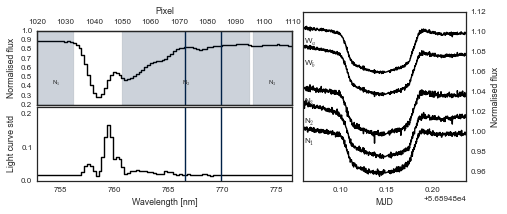

In [39]:
fig = figure(figsize=(AAPGW,0.85*AAOCW))
ax_spc = fig.add_axes([0.08,0.51,0.50,0.35])
ax_std = fig.add_axes([0.08,0.15,0.50,0.35])
ax_img = fig.add_axes([0.60,0.15,0.32,0.80])
ax_pix = ax_spc.twiny()

[ax_pix.axvspan(sl.start,sl.stop, alpha=0.2) for sl in slices_n]

ax_pix.text(cents[0], 0.42, 'N$_1$', ha='center')
ax_pix.text(cents[1], 0.42, 'N$_2$', ha='center')
ax_pix.text(cents[2], 0.42, 'N$_3$', ha='center')

ax_spc.plot(wlc[slice_w], spectra_tm[:,slice_w].mean(0)/2, 'k', drawstyle='steps-mid')
ax_std.plot(wlc[slice_w], normalise(spectra_tm[:,slice_w]/spectra_cm[:,slice_w]).std(0), 'k',
         drawstyle='steps-mid')

t = mjd[bmsk]
[ax_img.plot(t, lc+0.02*i, 'k') for i,lc in enumerate(lcr_n)]
ax_img.plot(t, mean(lcr_n,0)+0.08, 'k')
ax_img.plot(t, lcr_w+0.10, 'k')
[ax_img.text(t[2], 0.988+0.02*i , 'N$_'+str(i+1)+'$', size=8) for i in range(3)]
ax_img.text(t[2], 1.066, 'W$_b$', size=8)
ax_img.text(t[2], 1.088, 'W$_a$', size=8)

[ax.axvline(766.5, c=cp[0]) for ax in [ax_spc,ax_std]]
[ax.axvline(769.9, c=cp[0]) for ax in [ax_spc,ax_std]]

ax_pix.grid(False)
ax_img.yaxis.tick_right()
ax_img.yaxis.set_label_position('right')
setp(ax_pix, xlim=(slice_w.start,slice_w.stop), xlabel='Pixel')
setp(ax_spc, xlim=wlc[slice_w][[0,-1]], ylim=(0.2,1.0), ylabel='Normalised flux')
setp(ax_spc.get_xticklabels(), visible=False)
setp(ax_std, xlim=wlc[slice_w][[0,-1]], ylim=(0.0,0.22), yticks=[0,0.1,0.2],
     ylabel='Light curve std', xlabel='Wavelength [nm]')
setp(ax_img, ylabel='Normalised flux', xlabel='MJD', xlim=t[[0,-1]], ylim=(0.951,1.12))
fig.savefig('plots/potassium_detail.pdf')

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>